# Fused Softmax

This notebook is adapted from the Triton [fused softmax](https://triton-lang.org/master/getting-started/tutorials/02-fused-softmax.html#) tutorial.  

The softmax function is defined as:

$$
\text{Softmax}(\mathbf{\overrightarrow{x}})_i = \frac{e^{x_i}}{\sum_j{e^{x_j}}}
$$

In [1]:
import torch
import triton
import triton.language as tl

Naive softmax

In [46]:
@torch.jit.script
def naive_softmax(x):
    """
    Compute row-wise softmax of X using native pytorch.

    Note: The maximum element is substracted from all elements in order to avoid 
    overflows (i.e. numerical instability). Softmax is invariant to linear transformations. 
    """

    # read MN elements; write M elements
    x_max = x.max(dim=1).values
    
    # read MN + M elements; write MN elements
    z = x - x_max[:, None]
    
    # read MN elements; write MN elements
    numerator = torch.exp(z)
    
    # read MN elements; write M elements
    denominator = numerator.sum(dim=1)
    
    # read MN + M elements; write MN elements
    result = numerator / denominator[:, None]
    
    # In total read 5MN + 2M elements; wrote 3MN + 2M elements
    return result
                  

Fused softmax

In [47]:
@triton.jit
def softmax_kernel(
    output_ptr, 
    input_ptr, 
    input_row_stride, 
    output_row_stride, 
    n_cols,
    BLOCK_SIZE: tl.constexpr
):
    # The rows of the softmax are independent, so we parallelize across those
    row_idx = tl.program_id(0)

    # The stride represents how much we need to increase the pointer to advance 1 row.
    # It's equal to the number of elements in a row.
    row_start_ptr = input_ptr + row_idx * input_row_stride

    # The block size is the next power of two greater than n_cols, so we can fit each
    # row in a single block
    col_offsets = tl.arange(0, BLOCK_SIZE)
    input_ptrs = row_start_ptr + col_offsets
    # Load the row into SRAM, using a mask since BLOCK_SIZE may be > than n_cols
    row = tl.load(input_ptrs, mask=col_offsets < n_cols, other=-float('inf'))
    # Substract maximum for numerical stability
    row_minus_max = row - tl.max(row, axis=0)
    # Note that exponentials in Triton are fast but approximate (i.e., think __expf in CUDA)
    numerator = tl.exp(row_minus_max)
    denominator = tl.sum(numerator, axis=0)
    softmax_output = numerator / denominator
    # Write back output to DRAM
    output_row_start_ptr = output_ptr + row_idx * output_row_stride
    output_ptrs = output_row_start_ptr + col_offsets
    tl.store(output_ptrs, softmax_output, mask=col_offsets < n_cols)

Helper function for softmax kernel.

In [48]:
def softmax(x: torch.Tensor):

    n_rows, n_cols = x.shape
    # The block size is the smallest power of two greater than the number of columns in `x`
    BLOCK_SIZE = triton.next_power_of_2(n_cols)

    # Another trick we can use is to ask the compiler to use more threads per row by
    # increasing the number of warps (`num_warps`) over which each row is distributed.
    # Remember, a warp, from the hardware perspective, is a set of 32 threads 
    # that are execute the same instructions in parallel. 
    # You will see in the next tutorial how to auto-tune this value in a more natural
    # way so you don't have to come up with manual heuristics yourself.
    num_warps = 4
    if BLOCK_SIZE >= 2048:
        num_warps = 8
    if BLOCK_SIZE >= 4096:
        num_warps = 16
    # Allocate output
    y = torch.empty_like(x)
    # Enqueue kernel. The 1D launch grid is simple: we have one kernel instance per row o
    # f the input matrix
    softmax_kernel[(n_rows,)](
        y,
        x,
        x.stride(0),
        y.stride(0),
        n_cols,
        num_warps=num_warps,
        BLOCK_SIZE=BLOCK_SIZE,
    )
    return y

# Unit test

In [49]:
torch.manual_seed(0)
x = torch.randn(1823, 781, device='cuda')
y_triton = softmax(x)
y_torch = torch.softmax(x, axis=1)
assert torch.allclose(y_triton, y_torch), (y_triton, y_torch)

# Benchmark

In [44]:
%%capture
%pip install matplotlib pandas

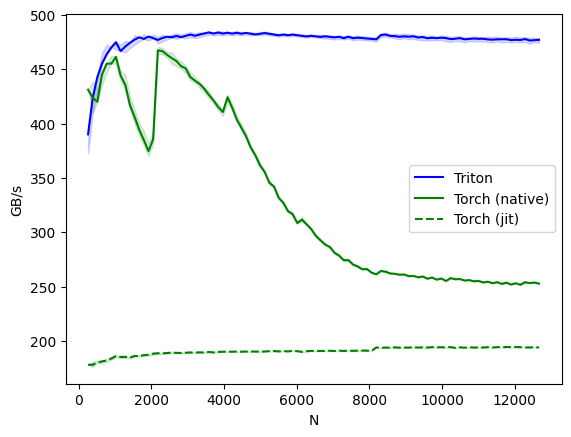

softmax-performance:
          N      Triton  Torch (native)  Torch (jit)
0     256.0  390.095241      431.157914   178.086953
1     384.0  423.724127      423.724127   178.086953
2     512.0  442.810792      420.102579   180.043953
3     640.0  455.111104      445.217381   181.238935
4     768.0  463.698115      455.111110   182.044451
..      ...         ...             ...          ...
93  12160.0  476.862754      251.694694   194.268608
94  12288.0  477.783730      254.015499   194.084891
95  12416.0  476.393282      253.226266   194.000000
96  12544.0  476.731587      253.734504   194.292362
97  12672.0  477.063523      252.798129   194.021045

[98 rows x 4 columns]


In [50]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N'],  # argument names to use as an x-axis for the plot
        x_vals=[
            128 * i for i in range(2, 100)
        ],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=[
            'triton',
            'torch-native',
            'torch-jit',
        ],  # possible values for `line_arg``
        line_names=[
            "Triton",
            "Torch (native)",
            "Torch (jit)",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-'), ('green', '--')],  # line styles
        ylabel="GB/s",  # label name for the y-axis
        plot_name="softmax-performance",  # name for the plot. Used also as a file name for saving the plot.
        args={'M': 4096},  # values for function arguments not in `x_names` and `y_name`
    )
)
def benchmark(M, N, provider):
    x = torch.randn(M, N, device='cuda', dtype=torch.float32)
    if provider == 'torch-native':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.softmax(x, axis=-1))
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: softmax(x))
    if provider == 'torch-jit':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: naive_softmax(x))
    gbps = lambda ms: 2 * x.nelement() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms), gbps(max_ms), gbps(min_ms)


benchmark.run(show_plots=True, print_data=True)